# Vane calibration (see also GBT memo 302)

In this notebook we cover some cases of receivers where a noise diode cannot be used to determine the system temperature.

ARGUS has a VANE/SKY calibration cycle, the W-band (3mm) receiver use a VANE as well to determine the system temperature via the "CALSEQ" procedure. The Q-band (7mm) receiver has a VANE, but also has noise diodes (which we don't use).

GBT memo 302 (2019, Frayer et al.) covers these cases.

### Data cases

A more expansive (spyder based) python script `test_vane.py` is available for extensive testing of 7 different cases. Some of them deal with very large (23GB) files and are not immediately suitable for a demonstration notebook such as this one.
Hence this notebook contains code to select a smaller subset of the data, but still showing the procedure. 

In [1]:
# @todo clean up some imports not needed anymore
import os
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
from scipy.stats import norm
from astropy.io import fits
import astropy.units as u

from dysh.fits.sdfitsload import SDFITSLoad
from dysh.fits.gbtfitsload import GBTFITSLoad
from dysh.util.files import dysh_data
from dysh.util.selection import Selection
from dysh.spectra.core import mean_tsys
# new
from dysh.fits.core import mean_data
from dysh.fits.core import getbeam
from dysh.fits.core import calseq
from dysh.fits.core import vanecal
from dysh.fits.core import plot_vegas      # different location ?
from dysh.fits.core import getnod          # should be done by official getnod

## Helper functions

In [2]:
def mkdir(name, clean=True):
    """ simple frontend for making a directory that might also already exist
        clean=True:    also remove files inside
    """
    os.makedirs(name, exist_ok = True)
    if clean:
        fns = os.listdir(name)
        for fn in fns:
            print(f"Removing {fn} from {name}")
            os.unlink(os.path.join(name,fn))

# 1. ARGUS : NGC5908

This edge2 takes too long, but has signal. Only need scans 329..334, but 327 is at 112 GHz, whereas 329 at 114GHz. Comparison ?

## Data loading and summary

In [3]:
# pick one of these
f2=dysh_data(test='AGBT21B_024_14/AGBT21B_024_14_test')    # this is the pytest, too few integrations to show spectrum
# f2=dysh_data('AGBT21B_024_14/AGBT21B_024_14.raw.vegas')  # takes very long
# f2 = 'edge2'                                             # this is just scans 329..334 and shows a spectrum
print(f2)
sdf2 = GBTFITSLoad(f2)


/home/teuben/GBT/redo/dysh2/testdata/AGBT21B_024_14/AGBT21B_024_14_test
Loaded 8 FITS files


In [4]:
sdf2.summary()

,SCAN,OBJECT,VELOCITY,PROC,PROCSEQN,RESTFREQ,DOPFREQ,# IF,# POL,# INT,# FEED,AZIMUTH,ELEVATIO
0,329,VANE,0.0,Track,1,114.03043,114.03043,1,1,1,16,333.863964,70.214864
1,330,SKY,0.0,Track,1,114.03043,114.03043,1,1,1,16,333.856661,70.214412
2,331,NGC5908,0.0,Nod,1,114.03043,114.03043,1,1,1,16,333.171573,70.123804
3,332,NGC5908,0.0,Nod,2,114.03043,114.03043,1,1,1,16,332.950559,70.04885
4,333,NGC5908,0.0,Nod,1,114.03043,114.03043,1,1,1,16,332.734249,70.008266
5,334,NGC5908,0.0,Nod,2,114.03043,114.03043,1,1,1,16,332.519705,69.928914


## Plotting the 16 ARGUS beams

Plotting total power and (normalized) Tsys for the 16 beams

/home/teuben/GBT/redo/dysh2/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


Showing total power for scans=[329]


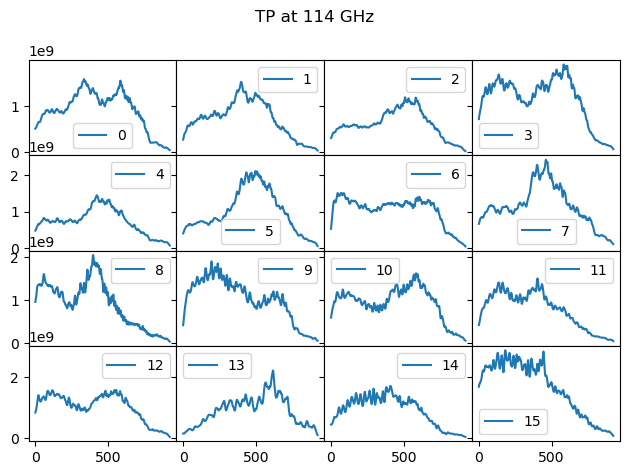

In [5]:
plot_vegas(sdf2,[329],"TP at 114 GHz")

Showing sky/(vane-sky) for scans=[329],scans+1


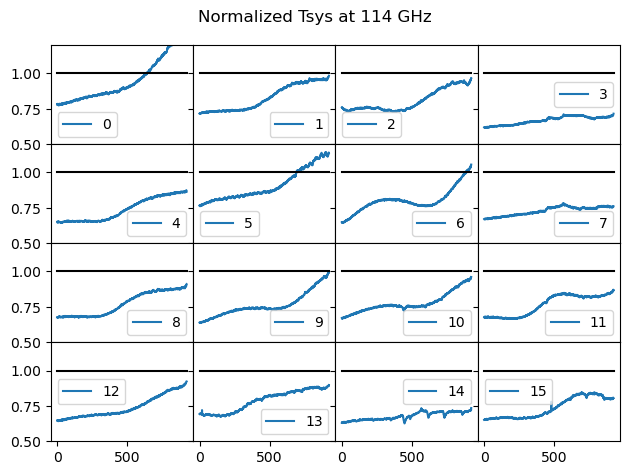

In [6]:
plot_vegas(sdf2,[329],"Normalized Tsys at 114 GHz",tsys=True, ylim=[0.5,1.2])

## Calibration

In [7]:
# determine the nodding beams
beam2 = getbeam(sdf2)   # 1,9
print("feeds",beam2)

# cheat here, for being offsite we can't yet get at tcal and used the previously determined Tcal 
tcal = 272    # via vanecal.pro on site


feeds [1, 9]


In [8]:
tsys2 = vanecal(sdf2, [329, 330], feeds=beam2, tcal=tcal)

fdnum,Tsys    1   221.79946
fdnum,Tsys    9   201.27396
<Tsys>  211.53671 +/- 10.26275
mode=2
TCAL= 272


In [9]:
print(tsys2)  # at 114 GHz

[221.79946241 201.2739606 ]


These system temperatures look reasonable compared to what was obtained online during the observation with the VANECAL procedure in GBTIDL

Note that both `beam2` and `tsys2` are vectors of length 2

## Gather the nodding spectra

In [10]:
sp1,sp2 = getnod(sdf2, [331, 332], beam2, tsys=tsys2)
sp3,sp4 = getnod(sdf2, [333, 334], beam2, tsys=tsys2)
sp3 = sp1.average([sp2,sp3,sp4])
object = sp3.meta['OBJECT']

Edges of spectrum are not great, take 50 off either end

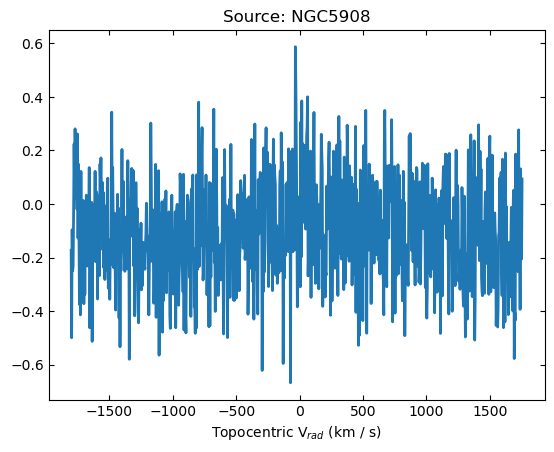

In [11]:
edge = 50
sp3[edge:-edge].plot(title=f"Source: {object}",xaxis_unit="km/s")

## Baseline subtraction and smoothing

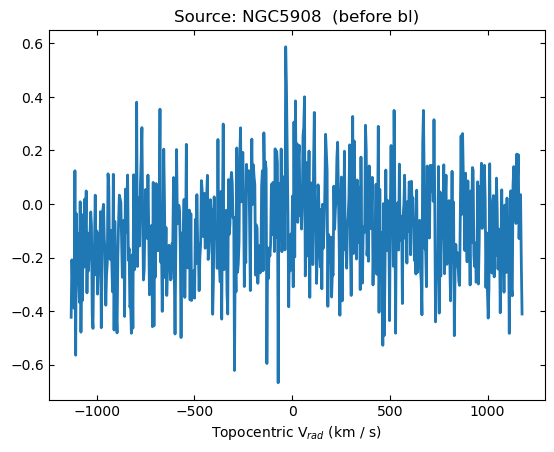

<QuantityModel Polynomial1D(9, c0=-0.01484546, c1=-0.05091137, c2=-1.05372583, c3=0.95119296, c4=3.88257231, c5=-2.78864093, c6=-5.57638837, c7=2.8376483, c8=2.62030001, c9=-0.84648245, domain=(114460430700.25, 113582989294.0)), input_units=Hz, return_units=>


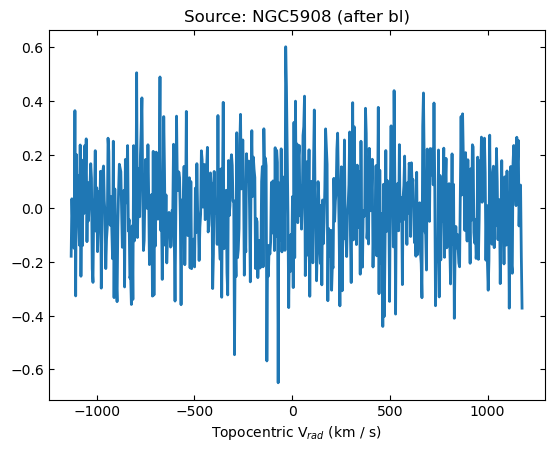

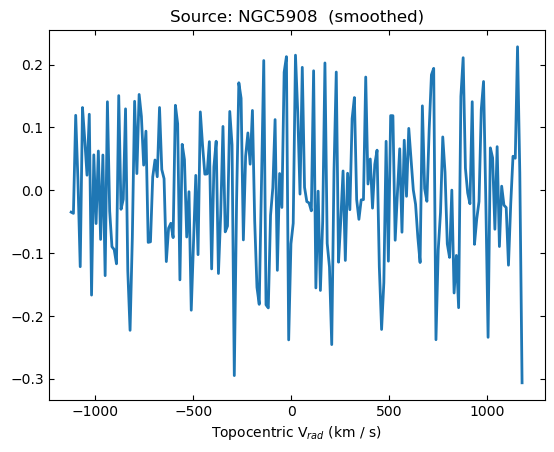

In [12]:
# do a baseline subtraction
kms = u.km/u.s
sp4=sp3[400:600]    # @todo need to figure this out in km/s   slciing should work in km/s too,but doesn't
sp4=sp3[350:650] 
sp4=sp3[300:700] 
sp4=sp3[200:800] 
#sp4=sp3
ebaselines=[-150*kms,150*kms]
ibaselines=[-150*kms,150*kms]
model="poly"
sp4.plot(title=f"Source: {object}  (before bl)",xaxis_unit="km/s")
#  include= two sections should work now [[-300,-150],[150,300]]
sp4.baseline(model=model, degree=9, exclude=ebaselines, remove=True)
#sp4.baseline(model=model, degree=5, include=ibaselines, remove=True)
# chebyshev', 'legendre', or 'hermite'
print(sp4.baseline_model)
sp4.plot(title=f"Source: {object} (after bl)",xaxis_unit="km/s")

sp5 = sp4.smooth('box', 3)
sp5.plot(title=f"Source: {object}  (smoothed)",xaxis_unit="km/s")


Although the line shape and location looks reasonable for a 6" beam at the center of this galaxy, the intensity seems a bit small. There are CARMA observations of this galaxy. Only for all integrations,the test data doesn't show anything.

#  2. M82 W-band (CALSEQ)

4 different IFs. Has signal in all but the first IF, but since IF's are overlapping, more interesting to plot them in one
spectrum.   We don't have tools for that, so there's a cheat in the end.

The full dataset is 729MB, which can be handled here if you have access to the full data.  There is also a smaller dataset available for testing purposes.

## Data loading and summary

In [13]:
f3 = dysh_data(accept='AGBT15B_244_07/AGBT15B_244_07.raw.vegas')
print(f3)
sdf3=GBTFITSLoad(f3, skipflags=True)

/home/teuben/GBT/dysh_data/acceptance_testing/data/AGBT15B_244_07/AGBT15B_244_07.raw.vegas
Loaded 8 FITS files


In [14]:
sdf3.summary()

,SCAN,OBJECT,VELOCITY,PROC,PROCSEQN,RESTFREQ,DOPFREQ,# IF,# POL,# INT,# FEED,AZIMUTH,ELEVATIO
0,130,M82,0.0,CALSEQ,1,87.645,86.4,4,2,41,2,334.375845,46.552969
1,131,M82,0.0,Nod,1,87.645,86.4,4,2,61,2,334.340511,46.455481
2,132,M82,0.0,Nod,2,87.645,86.4,4,2,61,2,334.420688,46.356491
3,133,M82,0.0,Nod,1,87.645,86.4,4,2,61,2,334.270943,46.255965
4,134,M82,0.0,Nod,2,87.645,86.4,4,2,61,2,334.352313,46.156723
5,135,M82,0.0,Nod,1,87.645,86.4,4,2,61,2,334.205169,46.05736
6,136,M82,0.0,Nod,2,87.645,86.4,4,2,61,2,334.287644,45.957891
7,137,M82,0.0,Nod,1,87.645,86.4,4,2,61,2,334.142569,45.858239
8,138,M82,0.0,Nod,2,87.645,86.4,4,2,61,2,334.225833,45.757117
9,139,M82,0.0,Nod,1,87.645,86.4,4,2,61,2,334.082225,45.655873


## Calibration

Determine the nodding beams (for this dual beam receiver it is also [0,1])

In [15]:
beams3 = getbeam(sdf3)    
print(beams3)

[0, 1]


Determine the Tsys and gain (K/counts) using the CALSEQ procedure

In [16]:
tsys3,g = calseq(sdf3, scan=130)     # 100.27992034259859, 9.129371938341321e-07

Twarm=261.1440751445086 Tcold=54
IFNUM 0 PLNUM 0 FDNUM 0
Tsys = 100.13203834626455
Gain [K/counts] = 9.115908926574802e-07


In [17]:
print(tsys3,g)  # 100.13203834626455 9.115908926574802e-07

100.13203834626455 9.115908926574802e-07


This particular result is for `ifnum=0` and `plnum=0`, but these data have 8 pairs of `(ifnum,plnum)`, so we need to loop
over them and get a table of Tsys.  I'm encoding the (ifnum,plnum) pair in a dictionary with key `ifnum*10+plnum`

In [18]:
tsys = {}
for ifnum in range(4):
    for plnum in range(2):
        tsys3,g = calseq(sdf3, 130, ifnum=ifnum, plnum=plnum)
        tsys[ifnum*10 + plnum] = tsys3
print(tsys)

Twarm=261.1440751445086 Tcold=54
IFNUM 0 PLNUM 0 FDNUM 0
Tsys = 100.13203834626455
Gain [K/counts] = 9.115908926574802e-07
Twarm=261.1440751445086 Tcold=54
IFNUM 0 PLNUM 1 FDNUM 0
Tsys = 141.3035080280017
Gain [K/counts] = 1.8207196144413296e-06
Twarm=261.1440751445086 Tcold=54
IFNUM 1 PLNUM 0 FDNUM 0
Tsys = 103.06355044800746
Gain [K/counts] = 8.488762353734731e-07
Twarm=261.1440751445086 Tcold=54
IFNUM 1 PLNUM 1 FDNUM 0
Tsys = 130.35541049332892
Gain [K/counts] = 1.3554620960177323e-06
Twarm=261.1440751445086 Tcold=54
IFNUM 2 PLNUM 0 FDNUM 0
Tsys = 103.10960383762362
Gain [K/counts] = 6.873156121415809e-07
Twarm=261.1440751445086 Tcold=54
IFNUM 2 PLNUM 1 FDNUM 0
Tsys = 125.20073849929193
Gain [K/counts] = 1.791725194410121e-06
Twarm=261.1440751445086 Tcold=54
IFNUM 3 PLNUM 0 FDNUM 0
Tsys = 108.58889074635587
Gain [K/counts] = 1.0816241061095478e-06
Twarm=261.1440751445086 Tcold=54
IFNUM 3 PLNUM 1 FDNUM 0
Tsys = 136.5830040203667
Gain [K/counts] = 2.611274488542018e-06
{0: 100.1320383

summarize the Tsys:

In [19]:
for t in tsys.keys():
    print(t,tsys[t])

0 100.13203834626455
1 141.3035080280017
10 103.06355044800746
11 130.35541049332892
20 103.10960383762362
21 125.20073849929193
30 108.58889074635587
31 136.5830040203667


## Gather the nodding spectra

The 2nd IF (`ifnum=1`) has a line at 87.3 GHz, though there's also a line for ifnum=2 (88.6), and two lines for ifnum=3 (88.6 and 89.1 GHz), obviously the different IFs overlap somewhat. The edges are noisy and we'll have to take off.

131
133
135
137
139


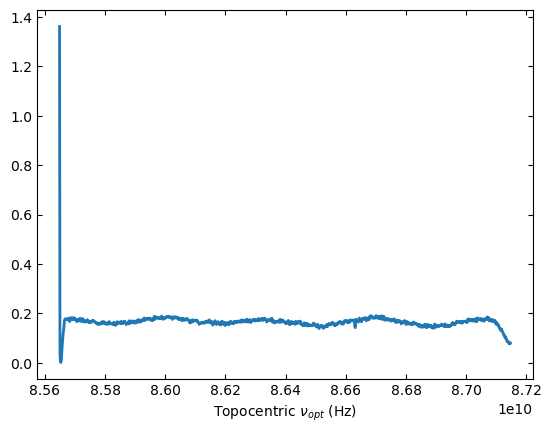

131
133
135
137
139


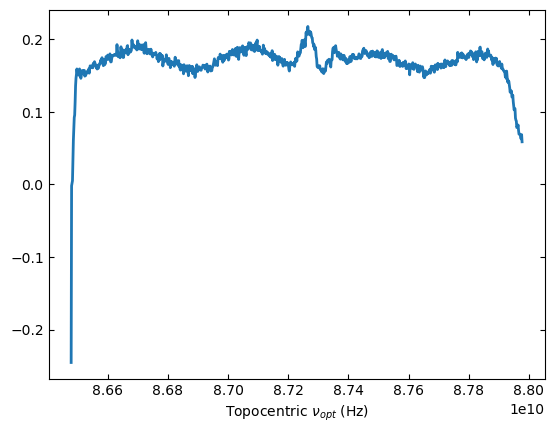

131
133
135
137
139


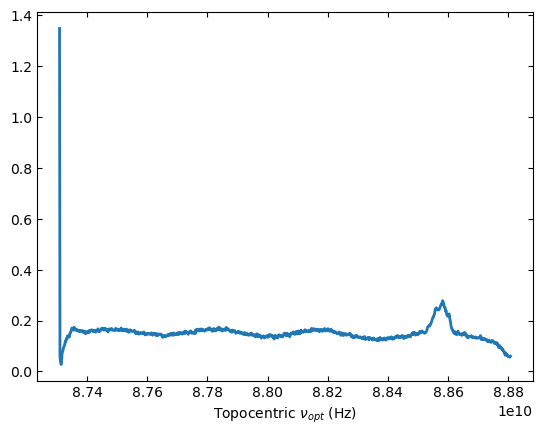

131
133
135
137
139


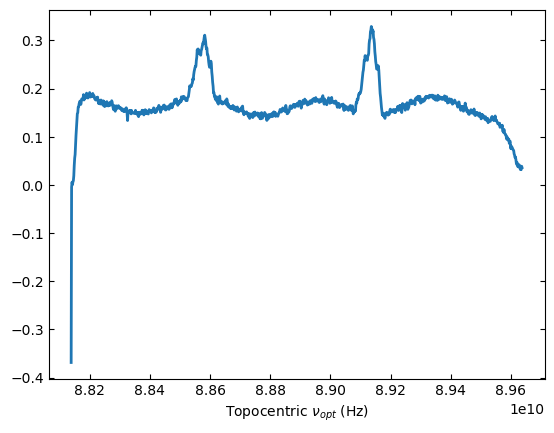

In [20]:
sp_final = list(range(4))

for ifnum in range(4):
    sp = []
    for s in range(131,140,2):
        print(s)
        sp1,sp2 = getnod(sdf3, [s,s+1], [0,1], plnum=0, ifnum=ifnum, tsys=tsys[ifnum*10 + 0])
        sp3,sp4 = getnod(sdf3, [s,s+1], [0,1], plnum=1, ifnum=ifnum, tsys=tsys[ifnum*10 + 1])
        sp.append(sp1)
        sp.append(sp2)
        sp.append(sp3)
        sp.append(sp4)

    # @todo these spectra don't contain the Tsys yet
    sp_final[ifnum] = sp[0].average(sp[1:]).smooth('gauss',16)
    sp_final[ifnum].plot()

the edges of the band disturb the scale, so lets plot the spectra with some edge taken off.
. These spectra have 1024 channels.

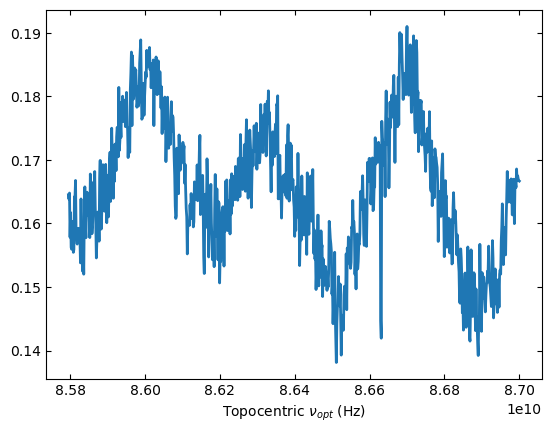

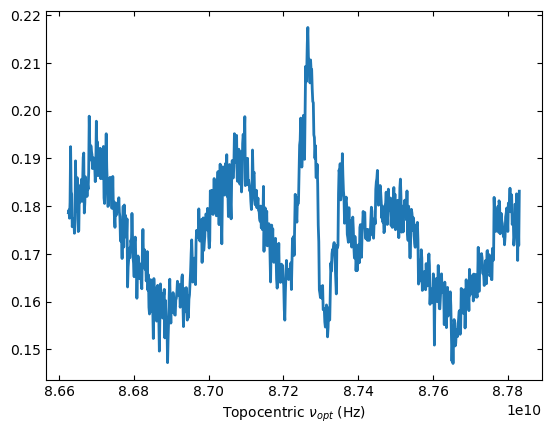

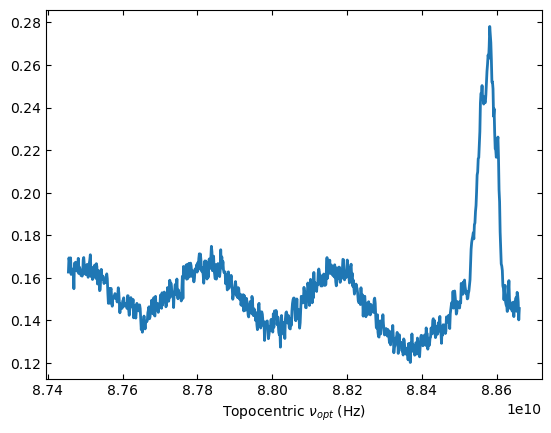

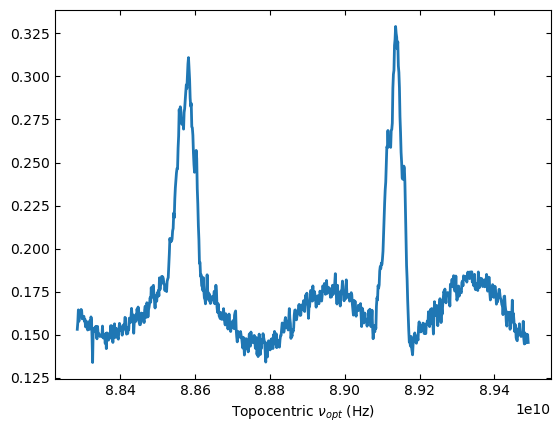

In [21]:
edge = 100

for ifnum in range(4):
    sp_final[ifnum][edge:-edge].plot()

## Baseline subtraction

In [22]:

kms = u.km/u.s
baselines = [ [-900*kms,-800*kms], [-600*kms,100*kms],[-2000*kms,-1500*kms], [(-1000*kms,-600*kms),(900*kms,1300*kms)] ] 


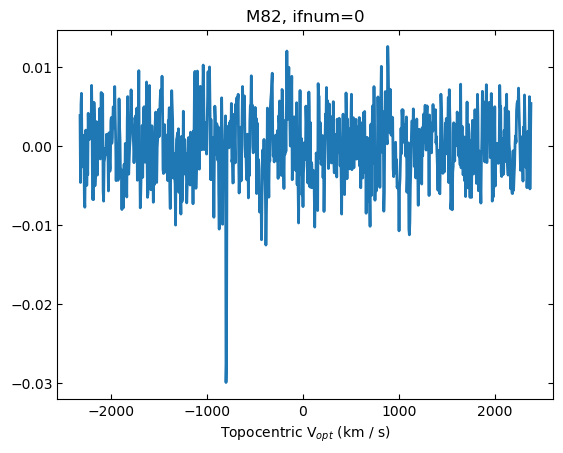

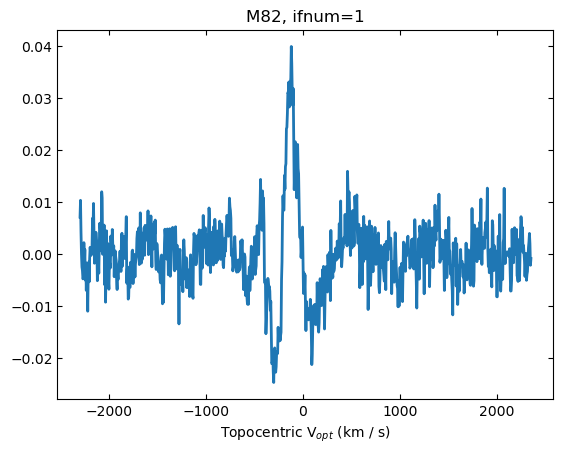

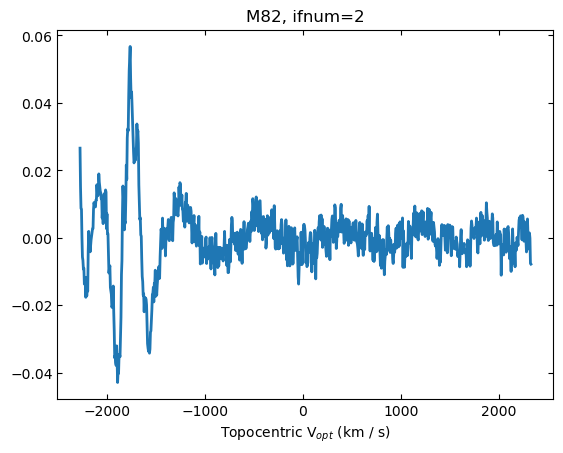

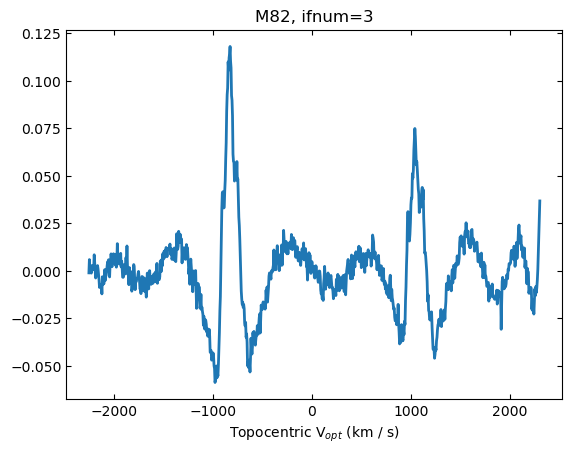

In [23]:
edge = 50
x = list(range(4))    # place holders to store spectra for each IF
y = list(range(4))
xunit="GHz"
xunit="km/s"
for ifnum in range(4):
    sp = sp_final[ifnum][edge:-edge] 
    object = sp.meta['OBJECT']
    sp.baseline(model="cheby", degree=15, remove=True, exclude=baselines[ifnum])
    sp.plot(xaxis_unit=xunit, title=f"{object}, ifnum={ifnum}")
    # sp.plot(xaxis_unit="km/s", title=f"{object}, ifnum={ifnum}")
    bl = baselines[ifnum]
    
    #    cheat and save the numerical values of the spectra for a composite view of the 4 IFs
    x[ifnum] = sp.frequency.value
    y[ifnum] = sp.flux.value


## Combining the 4 IF spectra

Now the cheat, the 4 IFs were stored in arrays x,y, so we can overlap them in one plot to get a combined view

Text(0.5, 1.0, 'M82')

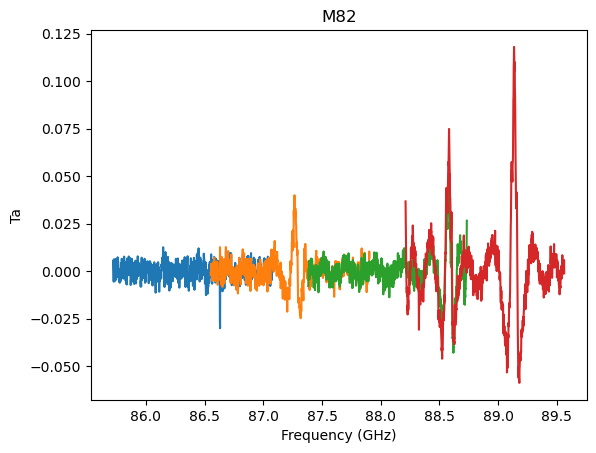

In [24]:
for i in range(4):
    plt.plot(x[i],y[i])
plt.xlabel("Frequency (GHz)")
plt.ylabel("Ta")
plt.title(f"{object}")

well, something not quite right with the baseline subtraction. units maybe wrong?  but at least the spectra sort of align in vertical scale.

more to come


* 88.63185 HCN
* 89.18853 HCO+

* VHEL = 269 km/s   dFreq ~ 0.08 GHz